In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from grid_method import *
from model import GHH

# week 6
## take x$\in$ $\mathbb{R}$,
## *f*(x) = $\sum_{k=1}^K$

In [ ]:
def norm_k(x_range, y_range, k_range, stepsize, n_iter):
    len_k_range = len(k_range)
    nb_pixels = ((x_range[1] - x_range[0])/stepsize + 1)**2
    result = np.zeros((len_k_range, n_iter*int(nb_pixels)))
    for i in range(len_k_range):
        k = k_range[i]
        norms = np.zeros((n_iter, int(nb_pixels)))
        for j in range(n_iter):
            grid, l = generate_grid(x_range, y_range, stepsize)
            grid.requires_grad_(True)
            ghh = GHH(grid, 2, k)
            output = ghh(grid)
            grad_x, grad_y = compute_grad(output, grid, l)
            norm = np.sqrt(grad_x**2 + grad_y**2)
            norm_1d = norm.flatten()
            norms[j] = norm_1d
        norms_1d = norms.flatten()
        result[i] = norms_1d
    return result

In [21]:
d = torch.linspace(-10,10,101)
d = torch.reshape(d, (-1,1))
d.requires_grad_(True)
d.shape

torch.Size([101, 1])

In [37]:
ghh = GHH(d, 1, 3)
output = ghh(d)

In [38]:
output.backward(torch.ones_like(output))

In [25]:
d_n = d.detach().numpy()
output_n = output.detach().numpy()

In [26]:
output_n = output_n.reshape(-1)
d_n = d_n.reshape(-1)

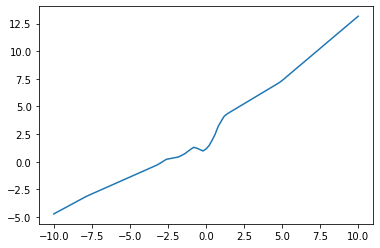

In [27]:
plt.plot(d_n, output_n)

### norm of the derivative

In [33]:
def norm(data):
    mean = torch.abs(data).mean()
    std = torch.abs(data).std()
    return mean.item(), std.item()

In [65]:
def test_norm(dim, ks, n_iter):
    avg_ms = []
    avg_stds = []
    for k in ks:
        stats = torch.empty(n_iter, 2)
        for i in range(n_iter):
            d = torch.linspace(-10, 10, 2001)
            d = d.reshape(-1,1)
            d.requires_grad_(True)
            ghh = GHH(d, dim, k)
            output = ghh(d)
            output.backward(torch.ones_like(output))
            m, std = norm(d.grad)
            stats[i,0] = m
            stats[i,1] = std
        avg_m = stats.mean(axis = 0)[0].item()
        avg_std = stats.mean(axis = 0)[1].item()
        avg_ms.append(avg_m)
        avg_stds.append(avg_std)
    return avg_ms, avg_stds

In [80]:
dim = 1; ks = np.arange(1,21);
ms, stds = test_norm(dim, ks, 10000)

In [81]:
ms_n = np.array(ms)
stds_n = np.array(stds)

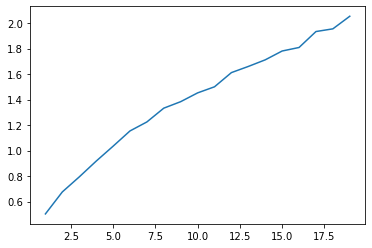

In [79]:
plt.plot(ks, ms_n)

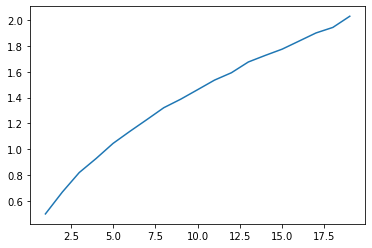

In [82]:
plt.plot(ks, ms_n)

In [83]:
ks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [34]:
m, std = norm(d.grad)

In [35]:
m,std

(0.945631206035614, 0.5069282650947571)

In [40]:
ghh.layer.weight

Parameter containing:
tensor([[-0.3218],
        [-0.2939],
        [-0.4433],
        [-0.1213],
        [ 0.7152],
        [ 0.1670]], requires_grad=True)

### distribution of the chosen weight for each base function

In [118]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
 
    def forward(self, x):
        return x.view(self.shape)

In [119]:
class grad_GHH(nn.Module):
    def __init__(self, data, d, k):
        super(grad_GHH, self).__init__()
        self.layer = nn.Linear(d, (d+1)*k)
        nn.init.uniform_(self.layer.weight,-1,1)
        nn.init.uniform_(self.layer.bias, -1,1)
        self.res1 = Reshape(1,data.shape[0],(d+1)*k)
        self.maxout = nn.MaxPool1d(d+1, stride = (d+1))
        self.res2 = Reshape(data.shape[0],k)
        
        
    def forward(self,x):
        output = self.layer(x)
        output = self.res1(output)
        output = self.maxout(output)
        output = self.res2(output)
        
        return output
    

In [121]:
d = torch.linspace(-10,10,101).reshape((-1,1))
#d = torch.reshape(d, (-1,1))
d.requires_grad_(True)
d.shape

torch.Size([101, 1])

In [122]:
ghh = grad_GHH(d, 1, 3)
output = ghh(d)
output1 = output[:,0]
output1.backward(torch.ones_like(output1))
alpha1 = d.grad

In [123]:
ghh.layer.weight

Parameter containing:
tensor([[-0.6591],
        [-0.1164],
        [ 0.5214],
        [ 0.3026],
        [-0.1406],
        [ 0.7728]], requires_grad=True)

In [129]:
set(alpha1.numpy().flatten())

{-0.659145, -0.11642122}

In [131]:
alpha1.mean()

tensor(-0.4388)

In [134]:
d = torch.linspace(-10,10,101).reshape((-1,1))
#d = torch.reshape(d, (-1,1))
d.requires_grad_(True)
output = ghh(d)
output2 = output[:,1]
output2.backward(torch.ones_like(output2))
alpha2 = d.grad

In [135]:
set(alpha2.numpy().flatten())

{0.3026086, 0.52141726}

In [136]:
alpha2.mean()

tensor(0.3763)

In [150]:
def chosen_weight(k):
    d = torch.linspace(-10,10, 2001).reshape((-1,1))
    d.requires_grad_(True)
    ghh = grad_GHH(d, 1, k)
    output = ghh(d)
    o1 = output[:, 0]
    o1.backward(torch.ones_like(o1))
    w1 = d.grad
    
    d = torch.linspace(-10,10, 2001).reshape((-1,1))
    d.requires_grad_(True)
    output = ghh(d)
    o2 = output[:, 1]
    o2.backward(torch.ones_like(o2))
    w2 = d.grad
    
    d = torch.linspace(-10,10, 2001).reshape((-1,1))
    d.requires_grad_(True)
    output = ghh(d)
    o3 = output[:, 2]
    o3.backward(torch.ones_like(o3))
    w3 = d.grad
    return w1, w2, w3

In [151]:
def test_chosen_weight(n_iter):
    stats = np.empty((n_iter, 3))
    for i in range(n_iter):
        w1, w2, w3 = chosen_weight(3)
        stats[i, 0] = w1.mean().item()
        stats[i, 1] = w2.mean().item()
        stats[i, 2] = w3.mean().item()
    avg_w1 = stats[:, 0].mean()
    avg_w2 = stats[:, 1].mean()
    avg_w3 = stats[:, 2].mean()
    
    return avg_w1, avg_w2, avg_w3

In [158]:
ks = np.arange(1,21)

w1, w2, w3 = test_chosen_weight(100000)

In [159]:
w1, w2, w3

(0.0015858801455858702, -0.0010541704279053783, -0.0004928209563229302)

In [ ]:
w1, w2, w3 = test_chosen_weight(100000)

In [ ]:
w1, w2, w3

In [ ]:
w1, w2, w3 = test_chosen_weight(100000)

In [ ]:
w1, w2, w3

In [163]:
def chosen_weight_2(k):
    d = torch.linspace(-10,10, 2001).reshape((-1,1))
    d.requires_grad_(True)
    ghh = grad_GHH(d, 1, k)
    output = ghh(d)
    o1 = output[:, 0]
    o1.backward(torch.ones_like(o1))
    w1 = d.grad
    
    d = torch.linspace(-10,10, 2001).reshape((-1,1))
    d.requires_grad_(True)
    output = ghh(d)
    o2 = output[:, 1]
    o2.backward(torch.ones_like(o2))
    w2 = d.grad
    return w1, w2

def test_chosen_weight_2(n_iter):
    stats = np.empty((n_iter, 2))
    for i in range(n_iter):
        w1, w2= chosen_weight_2(2)
        stats[i, 0] = w1.mean().item()
        stats[i, 1] = w2.mean().item()
    avg_w1 = stats[:, 0].mean()
    avg_w2 = stats[:, 1].mean()
    
    
    return avg_w1, avg_w2

# variation of the chosen weight

In [193]:
w1_1, w2_1 = test_chosen_weight_2(10)

In [194]:
w1_1, w2_1

(-0.10152989606722258, 0.11101523786783218)

In [195]:
w1_2, w2_2 = test_chosen_weight_2(100)

In [196]:
w1_2, w2_2

(0.03574941172264516, -0.05285398105625063)

In [197]:
w1_3, w2_3 = test_chosen_weight_2(1000)

In [198]:
w1_3, w2_3

(0.01430341588403826, -0.004590717411483638)

In [199]:
w1_4, w2_4 = test_chosen_weight_2(10000)

In [200]:
w1_4, w2_4

(-0.006151951691781869, -0.0006188259602726476)

In [191]:
w1_5, w2_5 = test_chosen_weight_2(100000)

In [201]:
w1_5, w2_5

(0.0009631696250804998, -0.0012879563391619711)

In [189]:
w1_6, w2_6 = test_chosen_weight_2(1000000)

In [202]:
w1_6, w2_6

(-0.0002366968045835527, 0.0005379786246376407)

In [204]:
w1s = [w1_1, w1_2, w1_3, w1_4, w1_5, w1_6]
w2s = [w2_1, w2_2, w2_3, w2_4, w2_5, w2_6]

In [205]:
n_iters = [10, 100, 1000, 10000, 100000, 1000000]

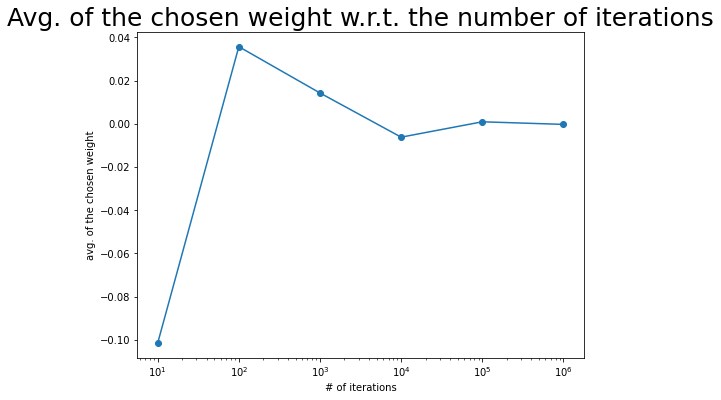

In [207]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(n_iters,w1s)
plt.plot(n_iters,w1s)
#plt.xscale("log")
plt.xlabel("# of iterations")
plt.ylabel("avg. of the chosen weight")
plt.title("Avg. of the chosen weight 1 w.r.t. the number of iterations",fontsize=25)
plt.show()

In [2]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(n_iters,w1s)
plt.plot(n_iters,w1s)
plt.axhline(y = 0.0, c="r", ls="--", lw=2)
#plt.xscale("log")
plt.xlabel("# of iterations")
plt.ylabel("avg. of the chosen weight")
plt.title("Avg. of the chosen weight 1 w.r.t. the number of iterations",fontsize=25)
plt.show()

NameError: name 'plt' is not defined

In [1]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(n_iters,w2s)
plt.plot(n_iters,w2s)

#plt.xscale("log")
plt.xlabel("# of iterations")
plt.ylabel("avg. of the chosen weight")
plt.title("Avg. of the chosen weight 2 w.r.t. the number of iterations",fontsize=25)
plt.show()

NameError: name 'plt' is not defined

In [218]:
def chosen_weight_dist(n_iter):
    for i in range(n_iter):
        w1, w2= chosen_weight_2(2)
        if i==0:
            w1_record = w1.numpy().transpose()
            w2_record = w2.numpy().transpose()
        else:
            w1_record = np.vstack((w1_record, w1.numpy().transpose()))
            w2_record = np.vstack((w2_record, w2.numpy().transpose()))
    return w1_record, w2_record

In [223]:
w1r, w2r = chosen_weight_dist(10000) 

In [247]:
w1r_flat = w1r.reshape(-1)

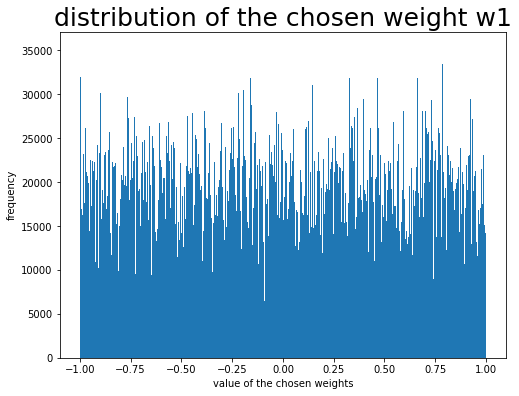

In [254]:
fig = plt.figure(figsize=(8, 6))
plt.hist(w1r_flat, bins = 1000)
plt.xlabel("value of the chosen weights")
plt.ylabel("frequency")
plt.title("distribution of the chosen weight w1",fontsize=25)
plt.show()

In [255]:
w2r_flat = w2r.reshape(-1)

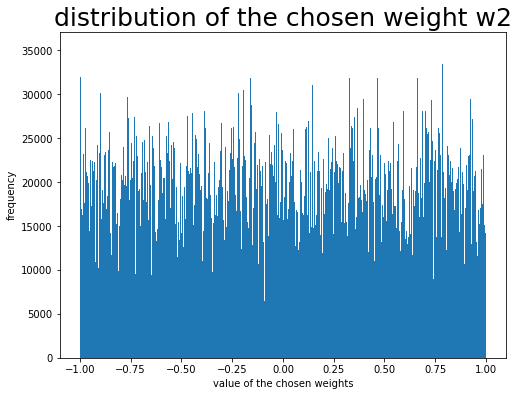

In [256]:
fig = plt.figure(figsize=(8, 6))
plt.hist(w1r_flat, bins = 1000)
plt.xlabel("value of the chosen weights")
plt.ylabel("frequency")
plt.title("distribution of the chosen weight w2",fontsize=25)
plt.show()

### The distribution of the chosen weights is still a uniform distribution between -1 and 1.